In [1]:
import webuiapi
import numpy as np
import cv2
from PIL import Image, ImageOps
api = webuiapi.WebUIApi()

def crop(img):
    new_width, new_height = [min(*img.size)]*2
    width, height = img.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img

In [2]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8x-seg.pt')#.to("mps")  # load an official model

In [3]:
img = Image.open("/Users/andrybin/Downloads/1647501730_41-almode-ru-p-svadba-v-stile-parizh-42.jpg")

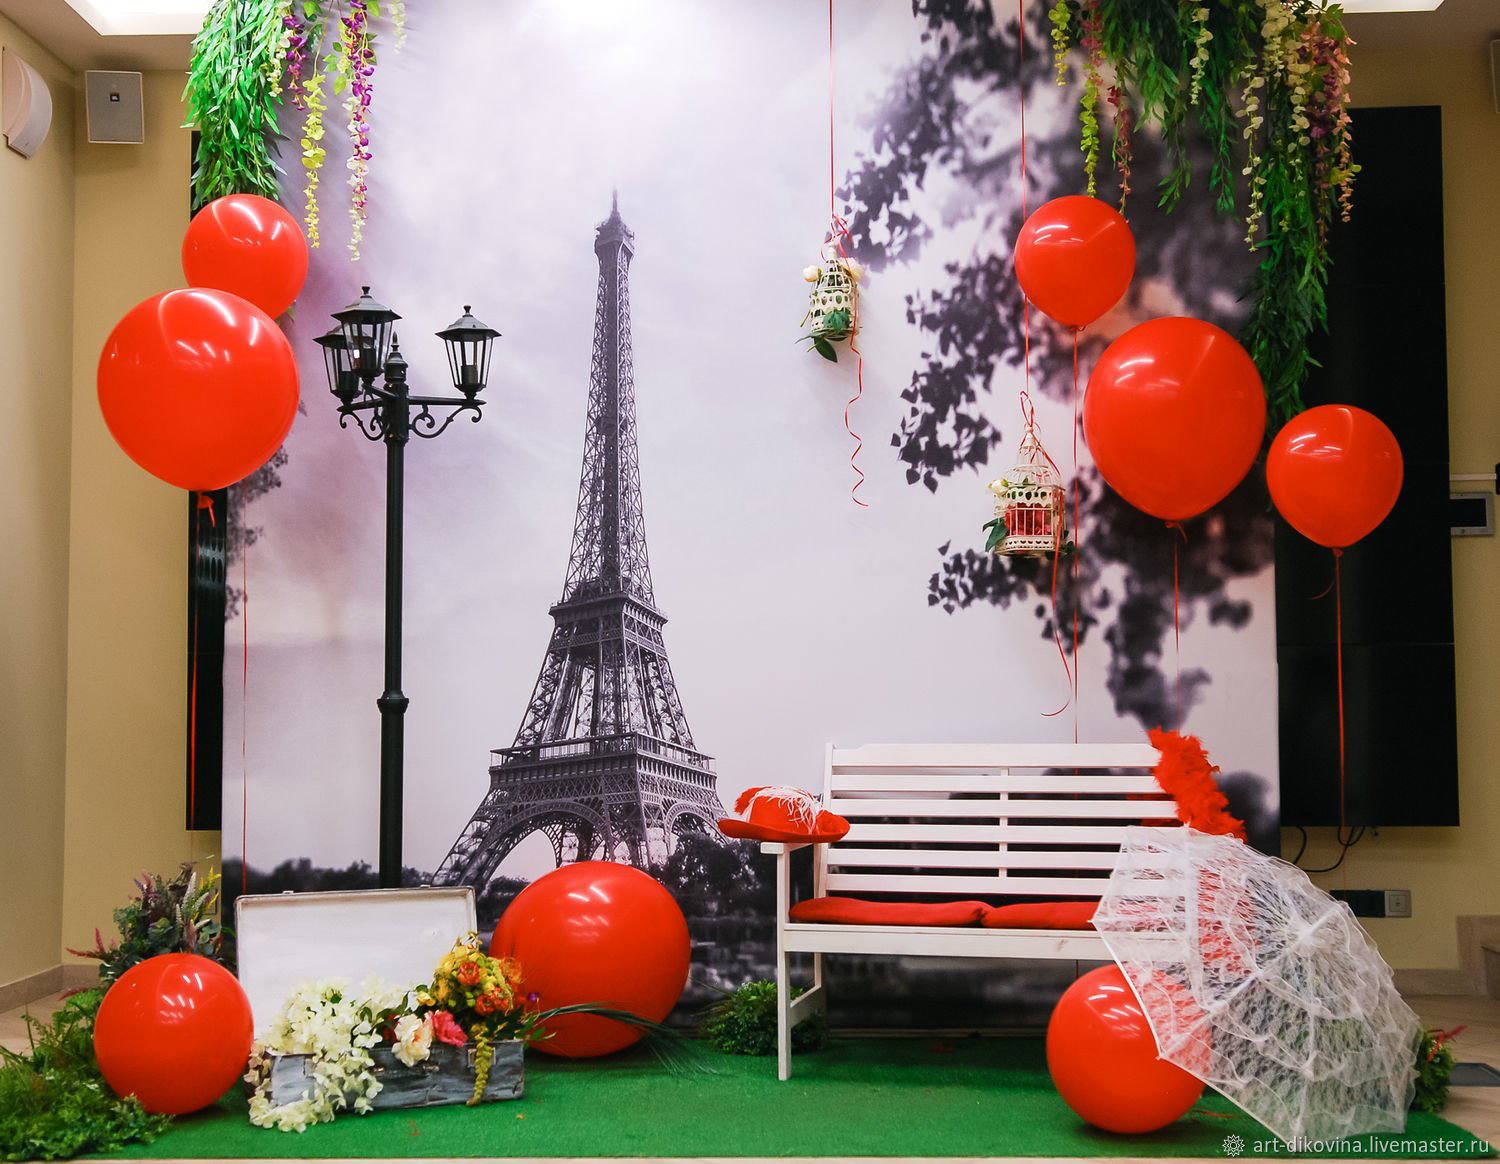

In [4]:
img


0: 640x640 1 bench, 1 umbrella, 1 sports ball, 2 potted plants, 585.1ms
Speed: 3.6ms preprocess, 585.1ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)


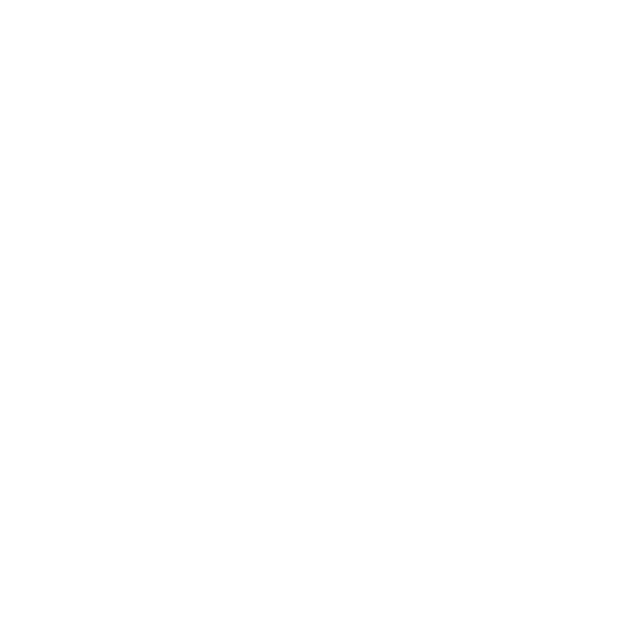

In [5]:
img = crop(img)
img = img.resize((640, 640))
# img = img.resize((960, 640)) if img.width > img.height else img.resize((640, 960))
results = model(img) 
mask = results[0].masks.data.cpu().numpy()
cls = results[0].boxes.cls
mask = mask[cls == 0]
mask = mask.sum(axis=0).clip(0, 1)*255
mask = mask.astype(np.uint8)
# kernel = np.ones((5,5),np.uint8)
# mask = cv2.dilate(np.array(mask),kernel,iterations = 10)
mask = Image.fromarray(mask).convert("RGB")#.resize((512, 512))
mask = ImageOps.invert(mask).resize(results[0].orig_shape[::-1])
mask

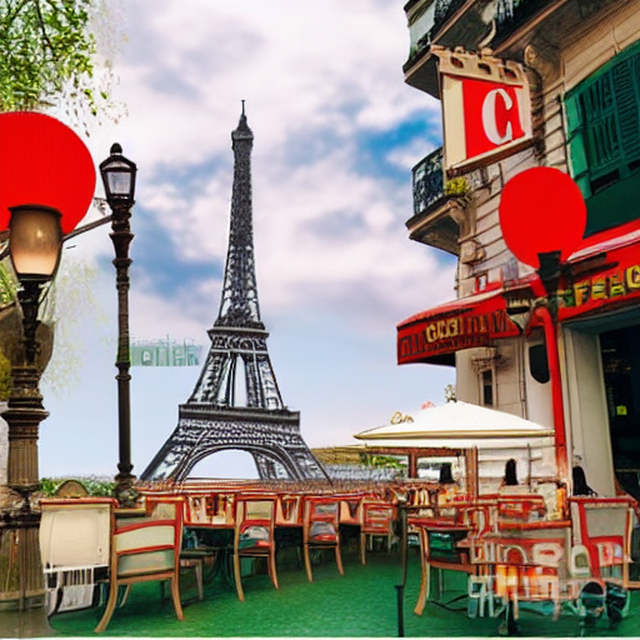

In [6]:
inpainting_result = api.img2img(images=[img],
                                resize_mode=2,
                                mask_image=mask,
                                inpainting_fill=1,
                                prompt="photo of historical caffe in Paris. eiffel tower on background. Very detailed and realistic image",
                                negative_prompt="person",
                                # seed=0,
                                steps=100,
                                mask_blur=4,
                                cfg_scale=7,
                                denoising_strength=0.6)
inpainting_result.image

In [25]:
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    # revision="fp16",
    torch_dtype=torch.float32
)
pipe = pipe.to("mps")
pipe.enable_attention_slicing()

text_encoder/model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:08<00:01,  1.48s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


100%|██████████| 60/60 [01:57<00:00,  1.96s/it]


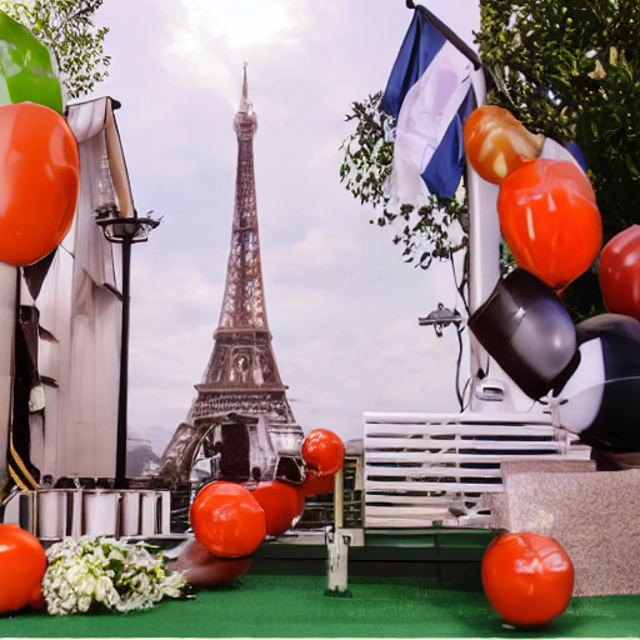

In [58]:
prompt = "photo of historical caffe in Paris. eiffel tower on background. Very detailed and realistic image"
image = pipe(prompt=prompt, image=img, mask_image=mask, num_inference_steps=100, strength=0.6, 
             guidance_scale=1, num_images_per_prompt=4).images[0]
img_out = np.array(image.resize((640, 640)))
masknp = np.array(mask, dtype=np.float32)/255
imgnp = np.array(img)
img_out = (img_out*masknp + img*(1-masknp)).astype(np.uint8)
Image.fromarray(img_out)